In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import time
from numpy.linalg import inv
import math
import random
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split

random.seed(9)

In [55]:
# Read pool of data points from hw3pool.txt
df = pd.read_csv("hw3pool.txt", sep=" ", header=None, names=['x', 'y'])
df.info()
display(df.head())

pool = df.to_numpy()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 30 entries, nan to nan
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       30 non-null     float64
 1   y       30 non-null     float64
dtypes: float64(2)
memory usage: 720.0 bytes


,x,y
NaN,2.374862,1.080289
NaN,2.946939,1.898605
NaN,1.650485,1.864033
NaN,3.270571,2.691074
NaN,1.168345,-3.032215


In [56]:
# This function implements the OLS estimator which takes in 1D features, x, expected values y as inputs, and returns two parameters
def ols_estimator_1d(x, y):
    
    m = x.shape[0] # Number of training examples
    
    # Dependent variable (1D) - X matrix
    X = np.array([np.ones(m), x]) 
    X = X.T # Transpose matrix to hold a shape of m x 2 to facilitate matrix multiplication of its transpose with vector y of shape m x 1 


    # Independent variable - y vector
    Y = y[..., None]

    # Implementing OLS Estimator
    # 1D OLS parameters - [\beta_{0}, \beta_{1}], y-intercept and gradient respectively
    betas = np.linalg.inv(X.T @ X) @ X.T @ Y 

    betas = betas.flatten()
    
    return betas

def regression_formula(x, beta1, beta2):
    return beta1 + beta2 * x

closeness = lambda a, b, p_a, p_b: (p_a - a)**2 + (p_b - b)**2

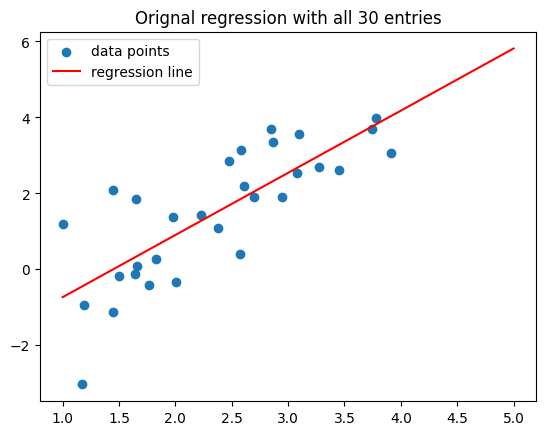

original beta 1: -2.370239547206875,
original beta 2: 1.637053151711282


In [57]:
# Run regression on all 30 entries
# On all 30 entries
x_all, y_all = pool.T
o_beta1, o_beta2 = ols_estimator_1d(x_all, y_all)

plt.scatter(x_all, y_all)

# Plot regression line
x_t = np.linspace(1,5, num=5)
plt.plot(x_t, regression_formula(x_t, o_beta1, o_beta2), c='red')

plt.title('Orignal regression with all 30 entries')
plt.legend(["data points", "regression line" ])
plt.show()

print(f'original beta 1: {o_beta1},\noriginal beta 2: {o_beta2}')

# Q1 

In [58]:

def find_combination(n, pool):
    dataset = combinations(pool, n)
    return np.array(list(dataset))

def find_best_teaching_set(n, greedy=False):

    minimum = math.inf
    best_local_minimum = 0
    best_teaching_set = None
    best_betas = None
    datasets = None 
    n_combinations = 0

    if greedy:
        start_dp_i = random.randint(0, len(df)-1)
        dataset = np.array([pool[start_dp_i]])
        filtered_pool = np.delete(pool, start_dp_i, axis=0)
        local_minimum = math.inf 
        size = 2
        
        while size <= n:
            for dp in filtered_pool:
                n_combinations += 1
                datapoint = np.array([dp])
                new_dataset = np.append(dataset, datapoint, axis=0)
                temp_ds = new_dataset.T
                betas = ols_estimator_1d(temp_ds[0], temp_ds[1])
                closeness_v = closeness(o_beta1, o_beta2, betas[0], betas[1])
                if closeness_v <= minimum:
                    best_teaching_set = new_dataset
                    best_betas = betas
                    minimum = closeness_v
                if closeness_v <= local_minimum:
                    best_teaching_set = new_dataset
                    best_betas = betas
                    local_minimum = closeness_v
                    best_local_minimum = local_minimum
      
            # Handle intermediate failure to seek better regression
            local_minimum = math.inf
            
            dataset = best_teaching_set
            # Remove data points from the pool which already exist in the best teaching set
            index_to_delete = np.where(filtered_pool == dataset[-1])
            filtered_pool = np.delete(filtered_pool, index_to_delete[0][0], axis=0)
            size+=1
            
        
        return best_teaching_set, best_betas, n_combinations, best_local_minimum 
    else: 
        datasets = find_combination(n, pool)
        
        for ds in datasets:
            temp_ds = ds.T
            betas = ols_estimator_1d(temp_ds[0], temp_ds[1])
            closeness_v = closeness(o_beta1, o_beta2, betas[0], betas[1])
            if(closeness_v <= minimum):
                best_teaching_set = ds
                best_betas = betas
                minimum = closeness_v

        n_combinations = len(datasets)
            
        return best_teaching_set, best_betas, n_combinations, minimum 
            
def run_and_time_function(func, *args):
    start = time.time()
    func(*args)
    end = time.time()
    return end-start

    
def print_metrics(n_teaching_size, time_cutoff, greedy= False):

    start = time.time()
    best_teaching_set, teaching_set_betas, n_combinations_iterated, closeness_measure = find_best_teaching_set(n_teaching_size, greedy)
    end = time.time()
    time_elapsed = end - start
   
    if time_elapsed < time_cutoff:
        # Show plot
        plt.scatter(x_all, y_all)

        # Plot original data points, and the original predicted regression line
        x_t = np.linspace(1,5, num=5)
        plt.plot(x_t, regression_formula(x_t, o_beta1, o_beta2), c='red')

        plt.title(f'Orignal regression with all 30 entries vs regression with best n={n_teaching_size} teaching data points')

        # Plot teaching data set used, and predicted regression line
        ts = best_teaching_set.T
        plt.scatter(ts[0], ts[1])
        plt.plot(x_t, regression_formula(x_t, teaching_set_betas[0], teaching_set_betas[1]))

        plt.legend(["original data points", "original regression line", "teaching data points", "teaching regression line" ])

        plt.show()

        print(f'Parameter loss (closeness measure): {closeness_measure}')
        print(f'Number of times need to fit OLS: {n_combinations_iterated}')
        print(f'Time elapsed to compute best teaching set: {time_elapsed}')
        return (closeness_measure, n_combinations_iterated, time_elapsed)
    
    return False 
    
    
def print_all_metrics_till_time_cutoff_seconds(start_n, time_cutoff, greedy = False):

    n = start_n 
    all_n_used = []
    all_closeness_measure = []
    all_n_combinations_iterated = []
    all_time_elapsed = [] 
    r = None 
    
    while (r := print_metrics(n, time_cutoff, greedy)):
        all_n_used.append(n)
        all_closeness_measure.append(r[0])
        all_n_combinations_iterated.append(r[1])
        all_time_elapsed.append(r[2]) 
        n+=1
        
    return all_n_used, all_closeness_measure, all_n_combinations_iterated, all_time_elapsed

## Q1. Finding teaching data points using normal enumeration technique 

Time cutoff used (s): 6.6


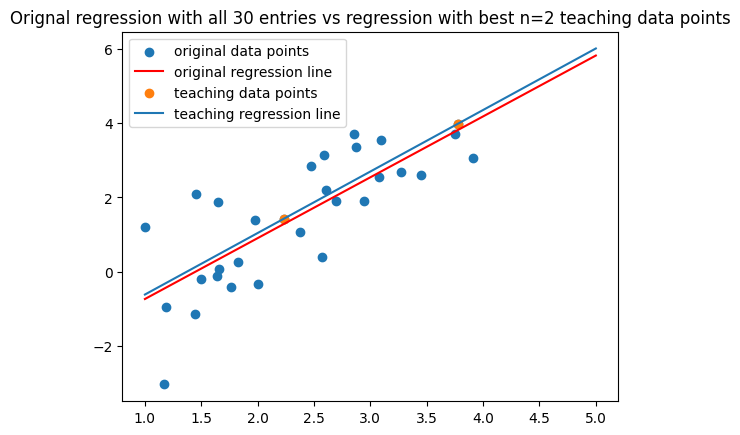

Parameter loss (closeness measure): 0.010804784411978798
Number of times need to fit OLS: 435
Time elapsed to compute best teaching set: 0.008153200149536133


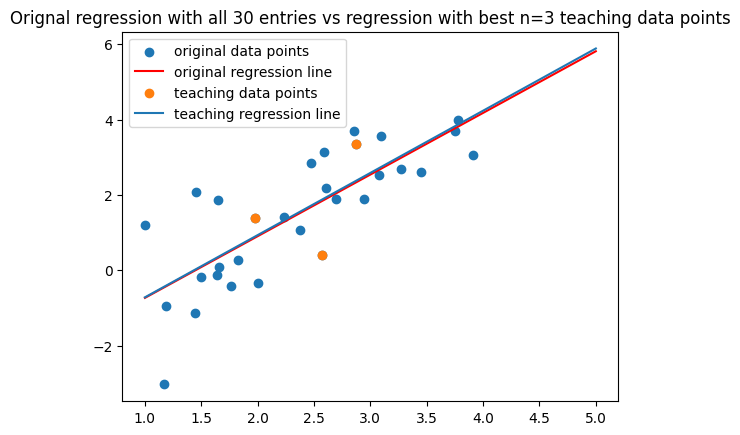

Parameter loss (closeness measure): 0.00021463796629338867
Number of times need to fit OLS: 4060
Time elapsed to compute best teaching set: 0.040042877197265625


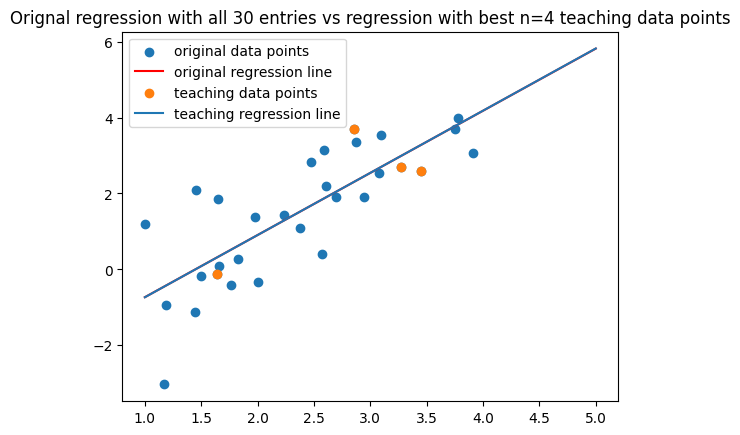

Parameter loss (closeness measure): 7.798436603588056e-06
Number of times need to fit OLS: 27405
Time elapsed to compute best teaching set: 0.2786891460418701


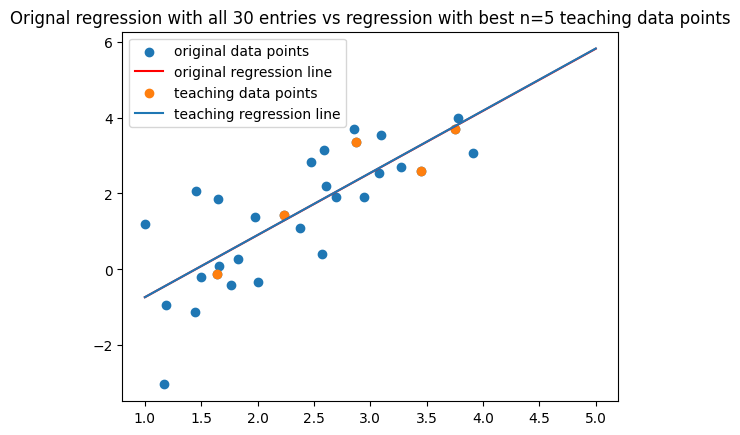

Parameter loss (closeness measure): 1.6605327753397655e-06
Number of times need to fit OLS: 142506
Time elapsed to compute best teaching set: 1.1064000129699707


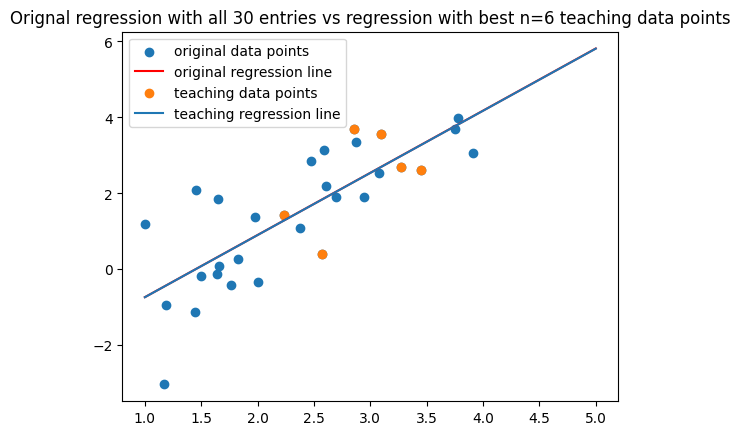

Parameter loss (closeness measure): 8.908127638734337e-07
Number of times need to fit OLS: 593775
Time elapsed to compute best teaching set: 4.709084987640381


In [59]:
time_cutoff = 6.6 
start_n = 2
greedy = False 
print(f'Time cutoff used (s): {time_cutoff}')

all_n_used, all_closeness_measure, all_n_combinations_iterated, all_time_elapsed = print_all_metrics_till_time_cutoff_seconds(start_n, time_cutoff, greedy)


# Q2

## Q2. Finding teaching data points using a greedy algorithm 

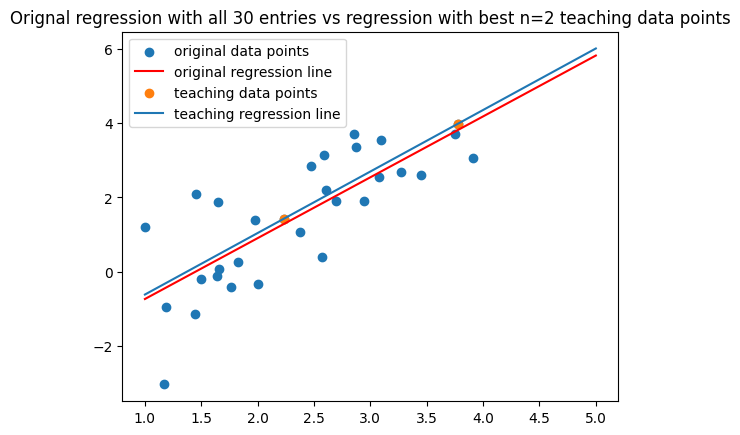

Parameter loss (closeness measure): 0.010804784411978798
Number of times need to fit OLS: 29
Time elapsed to compute best teaching set: 0.001088857650756836


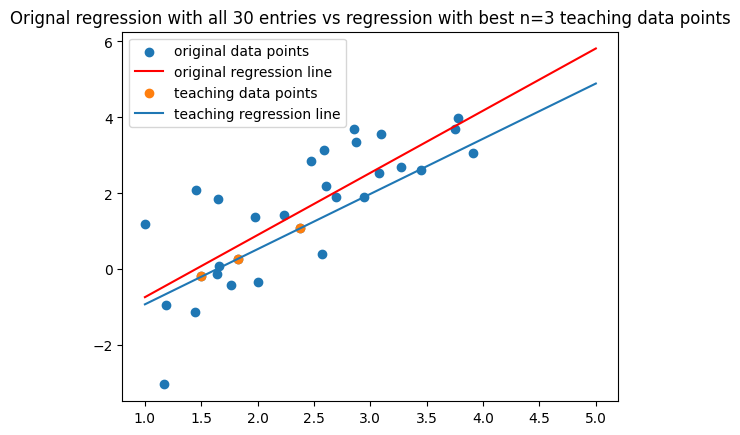

Parameter loss (closeness measure): 0.03369174494999296
Number of times need to fit OLS: 57
Time elapsed to compute best teaching set: 0.0008182525634765625


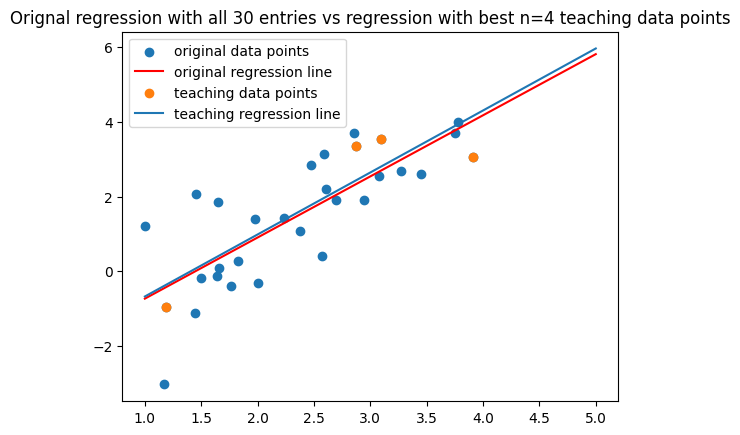

Parameter loss (closeness measure): 0.0017113000982662315
Number of times need to fit OLS: 84
Time elapsed to compute best teaching set: 0.0013229846954345703


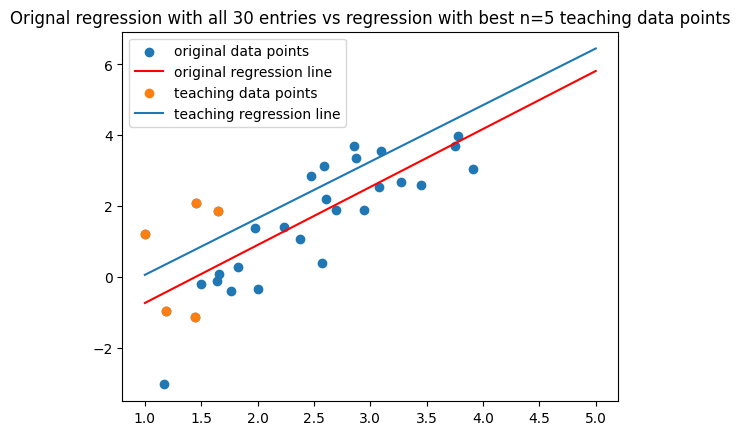

Parameter loss (closeness measure): 0.6970378742361192
Number of times need to fit OLS: 110
Time elapsed to compute best teaching set: 0.0015118122100830078


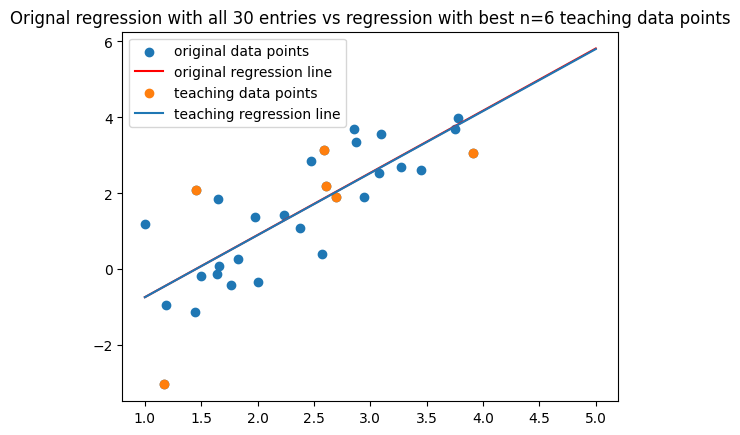

Parameter loss (closeness measure): 1.6731822989962904e-05
Number of times need to fit OLS: 135
Time elapsed to compute best teaching set: 0.0017170906066894531


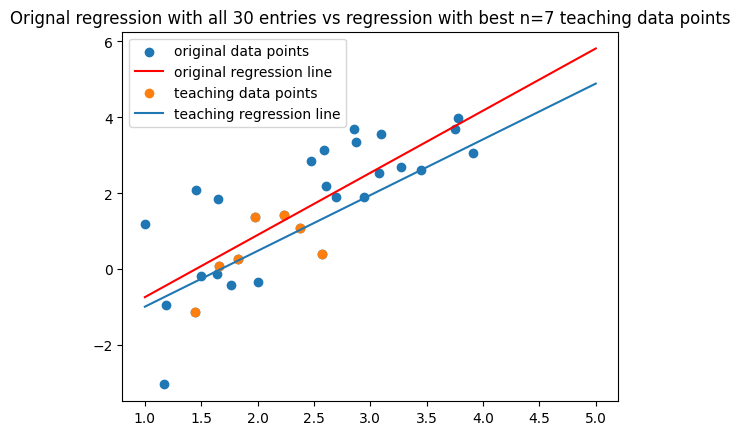

Parameter loss (closeness measure): 0.035175249932394945
Number of times need to fit OLS: 159
Time elapsed to compute best teaching set: 0.0020170211791992188


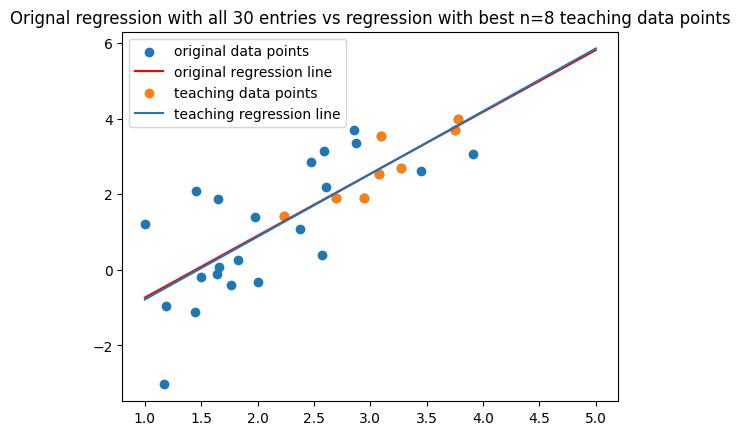

Parameter loss (closeness measure): 0.005831138463463111
Number of times need to fit OLS: 182
Time elapsed to compute best teaching set: 0.0022919178009033203


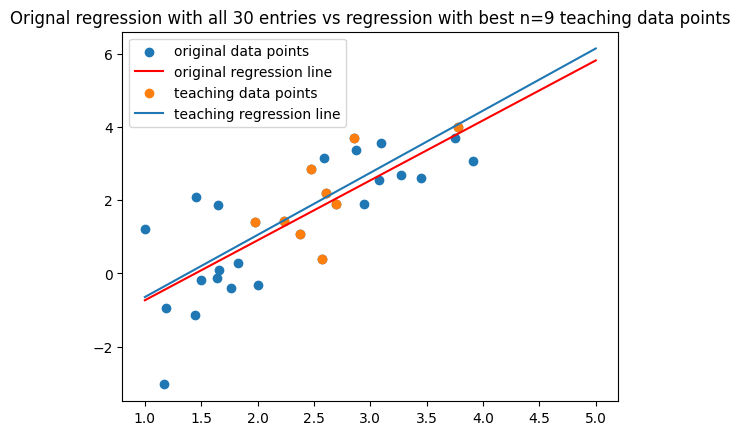

Parameter loss (closeness measure): 0.004341410903212521
Number of times need to fit OLS: 204
Time elapsed to compute best teaching set: 0.0036249160766601562


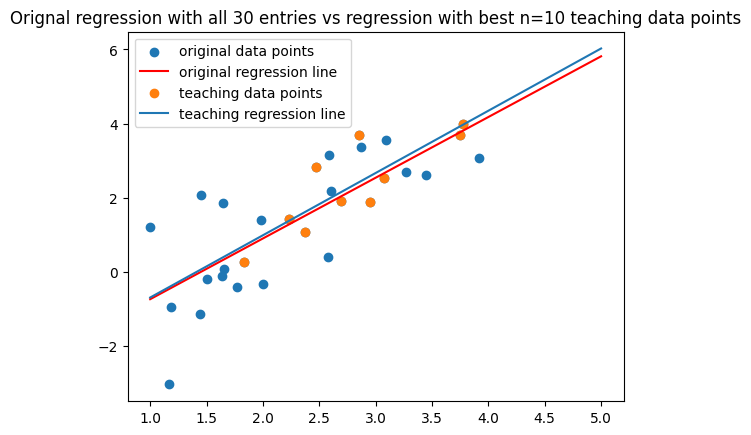

Parameter loss (closeness measure): 0.0017345437997494085
Number of times need to fit OLS: 225
Time elapsed to compute best teaching set: 0.0026466846466064453


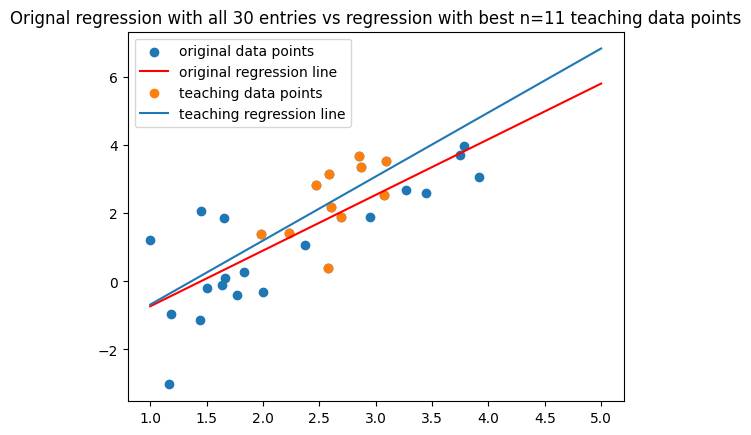

Parameter loss (closeness measure): 0.09860738798853627
Number of times need to fit OLS: 245
Time elapsed to compute best teaching set: 0.0028738975524902344


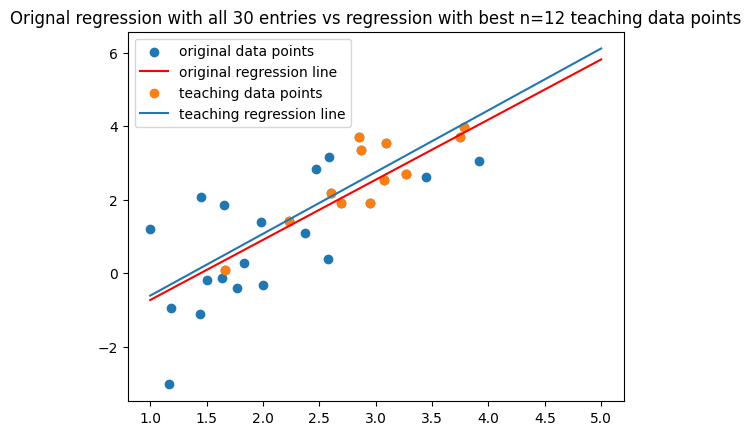

Parameter loss (closeness measure): 0.007664046696195317
Number of times need to fit OLS: 264
Time elapsed to compute best teaching set: 0.003087759017944336


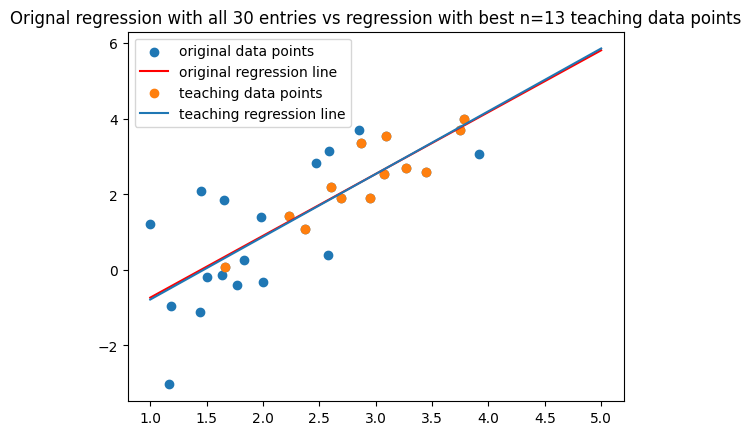

Parameter loss (closeness measure): 0.0062036729284308985
Number of times need to fit OLS: 282
Time elapsed to compute best teaching set: 0.0034220218658447266


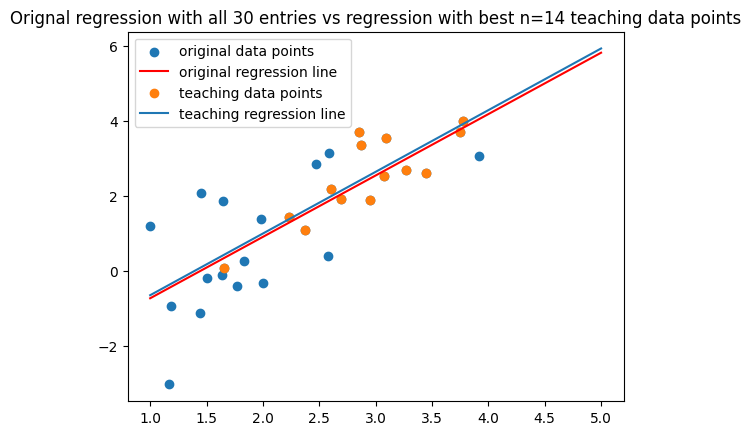

Parameter loss (closeness measure): 0.005543469451523216
Number of times need to fit OLS: 299
Time elapsed to compute best teaching set: 0.003762960433959961


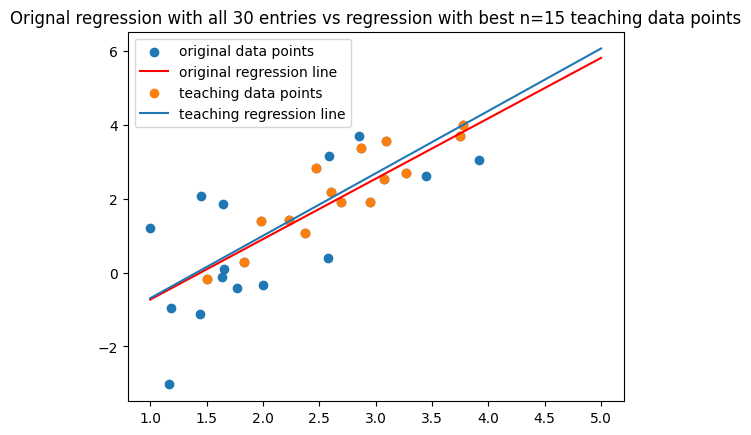

Parameter loss (closeness measure): 0.0032592849269071048
Number of times need to fit OLS: 315
Time elapsed to compute best teaching set: 0.003762960433959961


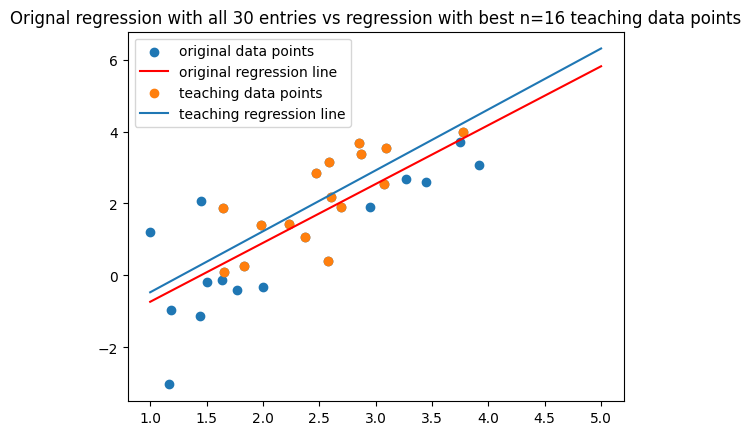

Parameter loss (closeness measure): 0.04599483558663174
Number of times need to fit OLS: 330
Time elapsed to compute best teaching set: 0.0037932395935058594


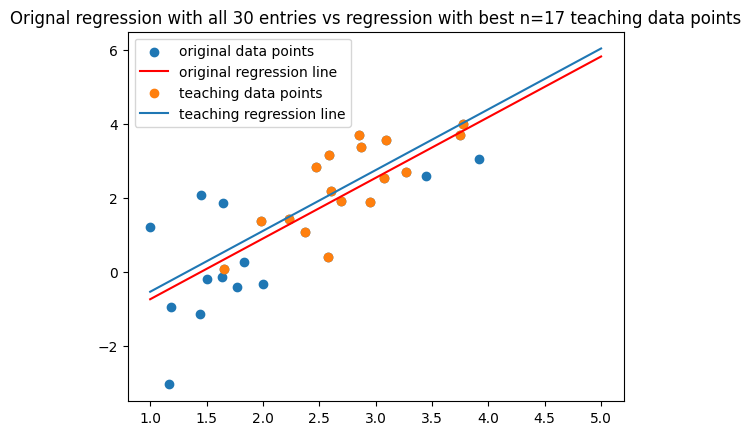

Parameter loss (closeness measure): 0.03949722850830043
Number of times need to fit OLS: 344
Time elapsed to compute best teaching set: 0.004892826080322266


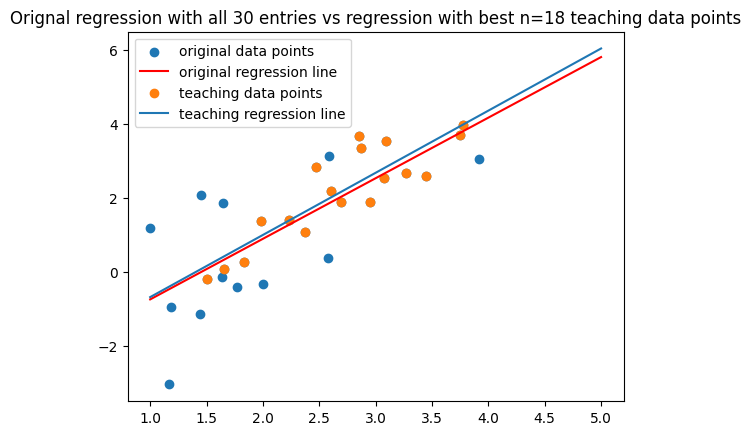

Parameter loss (closeness measure): 0.002180330545056997
Number of times need to fit OLS: 357
Time elapsed to compute best teaching set: 0.004121065139770508


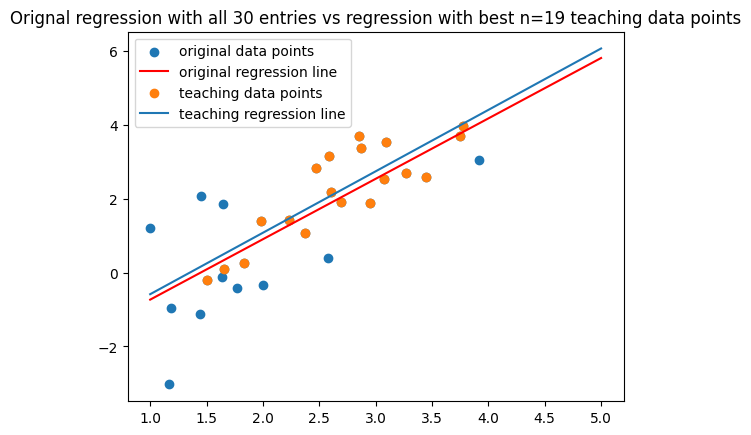

Parameter loss (closeness measure): 0.01514943355783586
Number of times need to fit OLS: 369
Time elapsed to compute best teaching set: 0.0046007633209228516


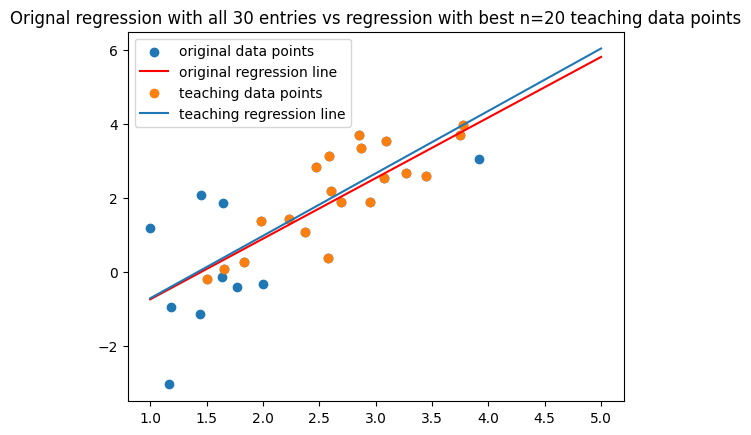

Parameter loss (closeness measure): 0.002955344701583009
Number of times need to fit OLS: 380
Time elapsed to compute best teaching set: 0.004601955413818359


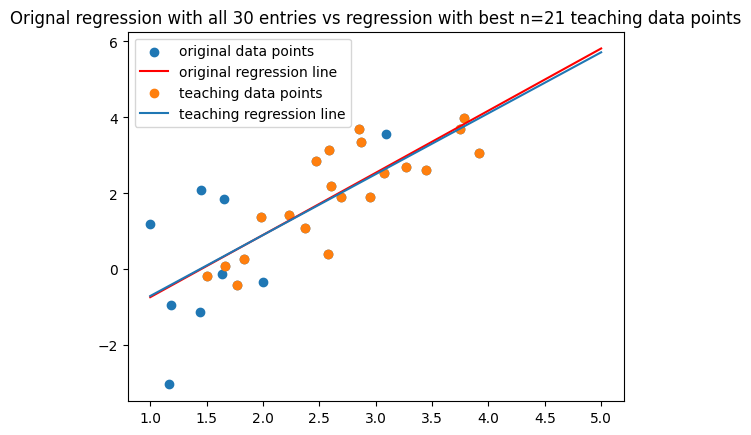

Parameter loss (closeness measure): 0.005019142707005925
Number of times need to fit OLS: 390
Time elapsed to compute best teaching set: 0.004832029342651367


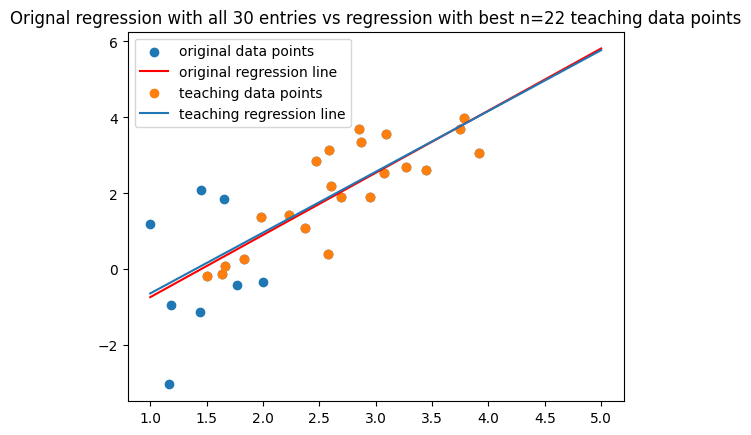

Parameter loss (closeness measure): 0.0193361158840371
Number of times need to fit OLS: 399
Time elapsed to compute best teaching set: 0.004710197448730469


In [60]:
time_cutoff = 0.005
start_n = 2
greedy = True 
all_n_used_greedy, all_closeness_measure_greedy, all_n_combinations_iterated_greedy, all_time_elapsed_greedy = print_all_metrics_till_time_cutoff_seconds(start_n, time_cutoff, greedy)

## Metrics: normal enumeration technique vs a greedy algorithm

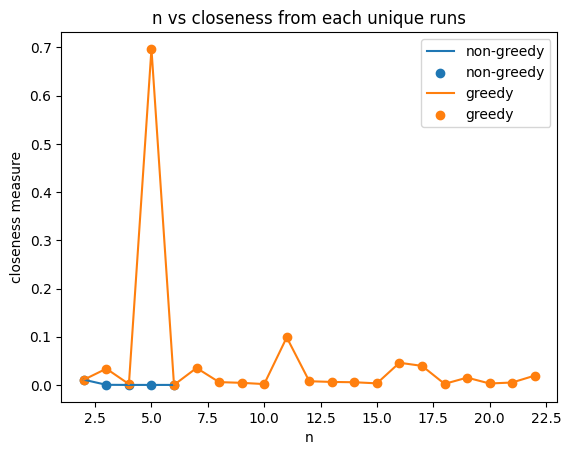

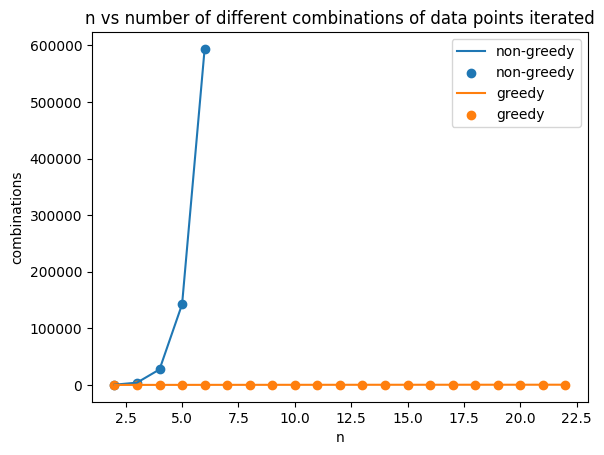

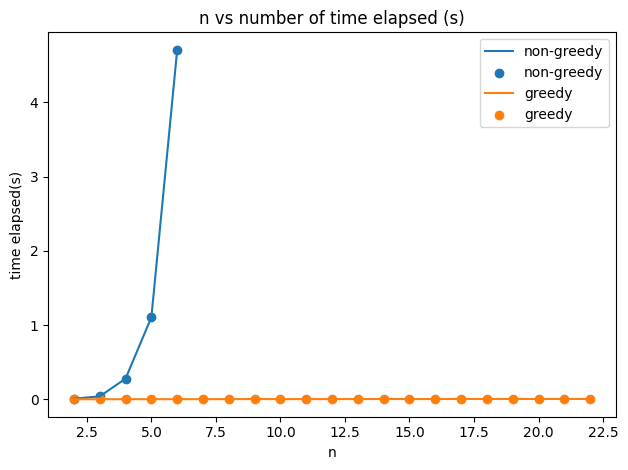

In [61]:
# Plot parameter loss with increasing nisinstance(temp_datasets, )
# Plot number of times needed to fit OLS with increasing n
# Plot time elapsed with increasing n

plt.plot(all_n_used, all_closeness_measure)
plt.scatter(all_n_used, all_closeness_measure)
plt.plot(all_n_used_greedy, all_closeness_measure_greedy)
plt.scatter(all_n_used_greedy, all_closeness_measure_greedy)
plt.xlabel('n')
plt.ylabel('closeness measure')
plt.title('n vs closeness from each unique runs')
plt.legend(['non-greedy','non-greedy','greedy','greedy'])
plt.show()

plt.plot(all_n_used, all_n_combinations_iterated)
plt.scatter(all_n_used, all_n_combinations_iterated)
plt.plot(all_n_used_greedy, all_n_combinations_iterated_greedy)
plt.scatter(all_n_used_greedy, all_n_combinations_iterated_greedy)
plt.xlabel('n')
plt.ylabel('combinations')
plt.title('n vs number of different combinations of data points iterated')
plt.legend(['non-greedy','non-greedy','greedy','greedy'])
plt.show()

plt.plot(all_n_used, all_time_elapsed)
plt.scatter(all_n_used,all_time_elapsed)
plt.plot(all_n_used_greedy, all_time_elapsed_greedy)
plt.scatter(all_n_used_greedy,all_time_elapsed_greedy)
plt.xlabel('n')
plt.ylabel('time elapsed(s)')
plt.title('n vs number of time elapsed (s)')
plt.legend(['non-greedy','non-greedy','greedy','greedy'])
plt.tight_layout()
plt.show()

> Notice the closeness measure of the greedy algorithm is highly variable. This is because each 'n' - teaching set size labeled as the x-axis are each unique restarts - hence forming 'n' unique runs of the greedy algorithm. The variability is caused by the randomly chosen start teaching datapoint of each run. 

For more accurate representation of closeness measure of running **one** greedy algorithm

### Observing the closeness measure of one run 

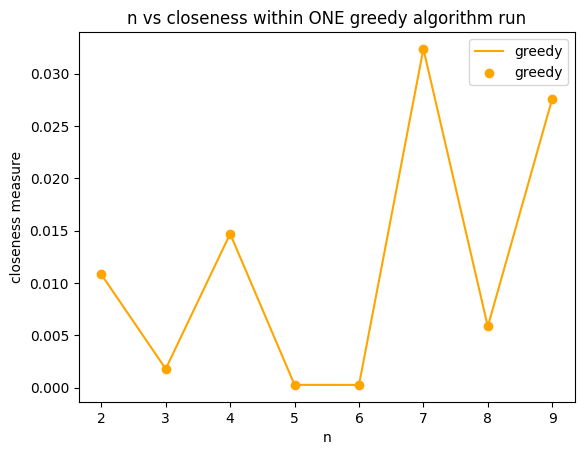

Parameter loss (closeness measure): 0.02758466814161921
Number of times need to fit OLS: 204
Time elapsed to compute best teaching set: 0.07797408103942871


In [62]:
random.seed(9)
def find_best_teaching_set_with_plots_greedy(n):

    minimum = math.inf
    best_local_minimum = 0
    best_teaching_set = None
    best_betas = None
    datasets = None 
    n_combinations = 0

    start_dp_i = random.randint(0, len(df)-1)
    dataset = np.array([pool[start_dp_i]])
    filtered_pool = np.delete(pool, start_dp_i, axis=0)
    local_minimum = math.inf 
    size = 2
    
    all_best_local_minimum = []

    while size <= n:
        for dp in filtered_pool:
            n_combinations += 1
            datapoint = np.array([dp])
            new_dataset = np.append(dataset, datapoint, axis=0)
            temp_ds = new_dataset.T
            betas = ols_estimator_1d(temp_ds[0], temp_ds[1])
            closeness_v = closeness(o_beta1, o_beta2, betas[0], betas[1])
            if closeness_v <= minimum:
                best_teaching_set = new_dataset
                best_betas = betas
                minimum = closeness_v
            if closeness_v <= local_minimum:
                best_teaching_set = new_dataset
                best_betas = betas
                local_minimum = closeness_v
                best_local_minimum = local_minimum

        # Handle intermediate failure to seek better regression
        local_minimum = math.inf

        dataset = best_teaching_set
       
        # Store each best closeness measure before plotting
        all_best_local_minimum.append(best_local_minimum)
        
        # Remove data points from the pool which already exist in the best teaching set
        index_to_delete = np.where(filtered_pool == dataset[-1])
        filtered_pool = np.delete(filtered_pool, index_to_delete[0][0], axis=0)
        size+=1

    # Plotting the closeness measure with each increment of n 
    all_best_local_minimum = np.array(all_best_local_minimum )
    plt.plot(np.arange(2,n+1),all_best_local_minimum, c='orange')
    plt.scatter(np.arange(2,n+1),all_best_local_minimum, c='orange')
    plt.title('n vs closeness within ONE greedy algorithm run')
    plt.xlabel('n')
    plt.ylabel('closeness measure')
    plt.legend(['greedy', 'greedy'])
    plt.show()
    return best_teaching_set, best_betas, n_combinations, best_local_minimum 

start = time.time()
best_teaching_set, teaching_set_betas, n_combinations_iterated, closeness_measure = find_best_teaching_set_with_plots_greedy(9)
end = time.time()
print(f'Parameter loss (closeness measure): {closeness_measure}')
print(f'Number of times need to fit OLS: {n_combinations_iterated}')
print(f'Time elapsed to compute best teaching set: {end-start}')

Much better variability

# Q3

,x,y,class_identifier
0,1.4,0.2,0.0
1,1.4,0.2,0.0
2,1.3,0.2,0.0
3,1.5,0.2,0.0
4,1.4,0.2,0.0
...,...,...,...
145,5.2,2.3,2.0
146,5.0,1.9,2.0
147,5.2,2.0,2.0
148,5.4,2.3,2.0


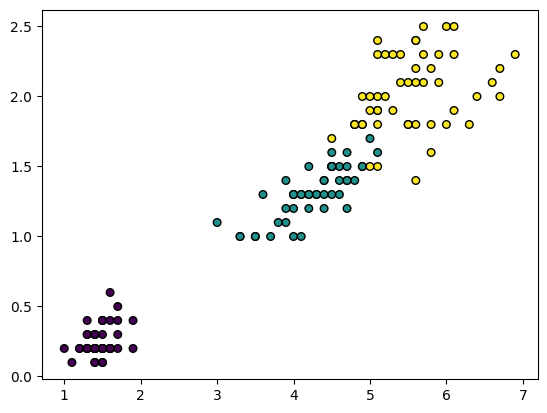

In [171]:
# import dataset from iris sklearn 
iris_ds = datasets.load_iris()
X, y = iris_ds.data, iris_ds.target

labels = ['purple', 'green', 'yellow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.8, random_state=13)

pool = np.array([X[:,2], X[:,3], y]).T
df = pd.DataFrame(pool, columns=['x', 'y', 'class_identifier'])
display(df)

plt.figure()
plt.scatter(X[:,2], X[:,3], c=y, edgecolor='k', s=30)
plt.show()

data point: [4, 1.5]
predicted result : 1.0
predicted color: green


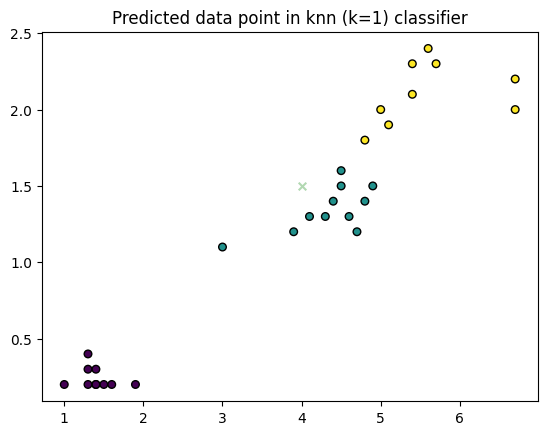

In [208]:
def euclidean_distance(x_s,y_s):
    # Iterates each element from both arrays, take its difference and power 2 before square root
    return np.sqrt(np.sum((x_s-y_s)**2))

def knn(k, predicted_dp, pool):
    distances = [euclidean_distance(np.array([predicted_dp[0], predicted_dp[1]]),np.array([x, y])) for x, y, class_id in pool]
    vote_pool_indices = np.argsort(distances)[:k]
    vote_pool_classes = [pool[i][2] for i in vote_pool_indices]
    vote_result = Counter(vote_pool_classes).most_common()
    
    return vote_result[0][0]
    
# Run knn
predicted_datapoint = [4, 1.5]
training_pool = np.array([X_train[:,2], X_train[:,3], y_train]).T
result = knn(1, predicted_datapoint, training_pool)
print(f'data point: {predicted_datapoint}')
print(f'predicted result : {result}')
print(f'predicted color: {labels[int(result)]}')

plt.figure()
plt.title('Predicted data point in knn (k=1) classifier')
plt.scatter(X_train[:,2], X_train[:,3], c=y_train, edgecolor='k', s=30)
plt.scatter([predicted_datapoint[0]], [predicted_datapoint[1]], c=labels[int(result)], s=30, alpha=0.3, marker='x')
plt.show()

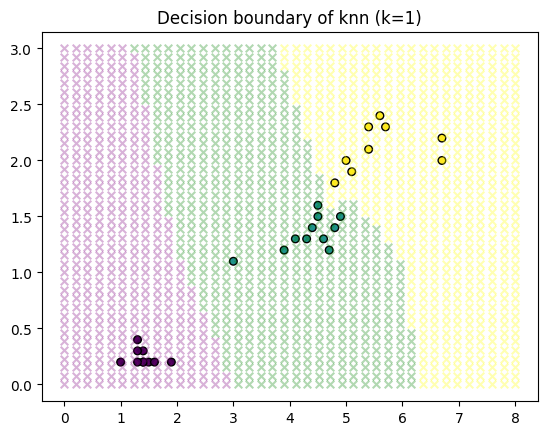

In [212]:
# Dense 2D grid to show decision boundary 
mesh_X, mesh_Y = np.mgrid[0:8:40j,0:3:40j]

plt.figure()
plt.title('Decision boundary of knn (k=1)')
plt.scatter(X_train[:,2], X_train[:,3], c=y_train, edgecolor='k', s=30)

for c_x, c_y in zip(mesh_X, mesh_Y):
    for x,y in zip(c_x, c_y):
        result = knn(1, [x,y], training_pool)
        plt.scatter([x], [y], c=labels[int(result)], s=30, alpha=0.3, marker='x')
        
plt.show()

High bias is observed with visible overfitting

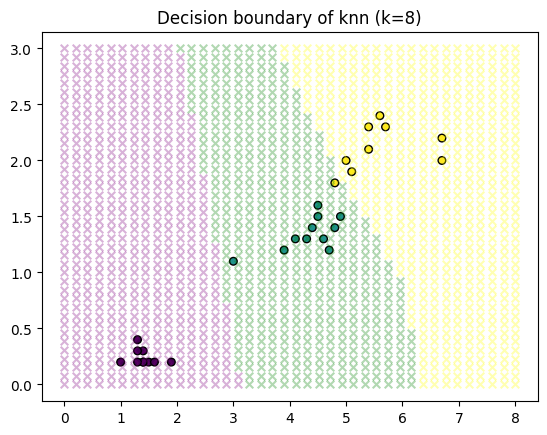

In [213]:
plt.figure()
plt.title('Decision boundary of knn (k=8)')
plt.scatter(X_train[:,2], X_train[:,3], c=y_train, edgecolor='k', s=30)

for c_x, c_y in zip(mesh_X, mesh_Y):
    for x,y in zip(c_x, c_y):
        result = knn(8, [x,y], training_pool)
        plt.scatter([x], [y], c=labels[int(result)], s=30, alpha=0.3, marker='x')
        
plt.show()